# Pneumonia detection from X-ray images using Deep Learning

## Main objective

Build an algorithm (CNN-VGG16) to automatically identify whether a patient is suffering from pneumonia or not by looking at chest X-ray images.

![](https://www.kdnuggets.com/wp-content/uploads/sagar-pneumonia-0.jpeg)


Author: Luis Fernando Salazar Salinas
Date: 16/08/2021

## Pneumomia dataset

-The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal)(Kermany,Kang Zhang and Goldbaum, 2018).

url: https://data.mendeley.com/datasets/rscbjbr9sj/2


In [1]:
## Libreries 
import sys, os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.grid(b=None)
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore')
import seaborn as sns
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as k
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPooling2D, SeparableConv2D, Dropout
from tensorflow.keras.layers import Flatten, GlobalAveragePooling2D, Add, Activation, BatchNormalization, ZeroPadding2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

## Load the dataset



In [2]:
## Conection with Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
## Import dataset
input_path = '/content/drive/MyDrive/Pneumonia_dataset/chest_xray/'

## Normal and pneumonia images

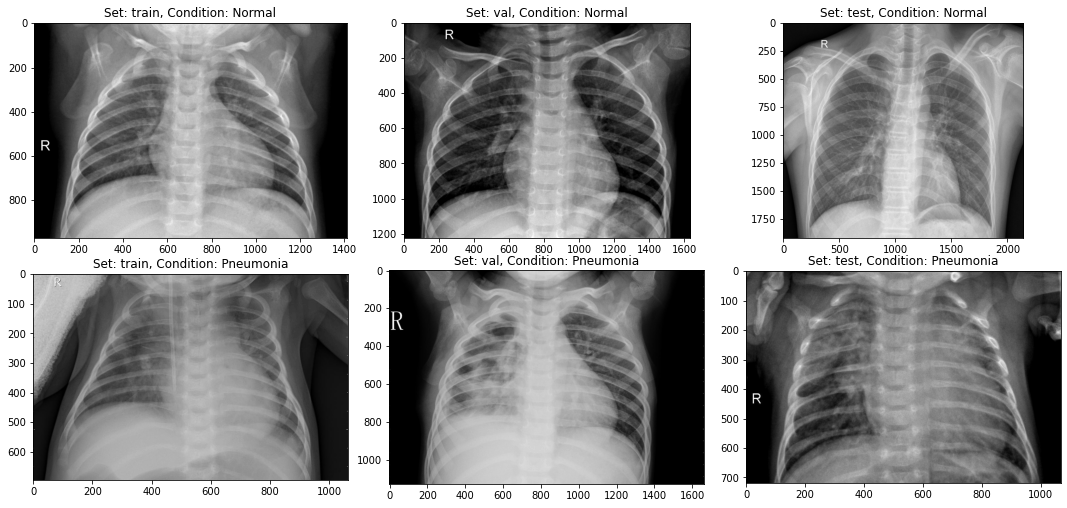

In [4]:
## Display some normal and pneumonia images

fig, ax = plt.subplots(2,3, figsize=(15,7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train','val','test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [5]:
## Total set of data
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 1341, pneumonia images: 3875
Set: val, normal images: 8, pneumonia images: 8
Set: test, normal images: 234, pneumonia images: 390


## Data preprocessing
- Data split
- Data normalization
- Data augmentation

In [ ]:
def preprocess_data(img_dims, batch_size):
    
    ## Training data
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                       zoom_range=0.3, 
                                       vertical_flip=True
                                   )
    ## Train generator
    train_gen = train_datagen.flow_from_directory(directory = input_path + 'train',
                                                  target_size = (img_dims, img_dims),
                                                  batch_size = batch_size,
                                                  class_mode = 'binary',
                                                  shuffle = True)
    ## Validation Data
    
    validation_datagen = ImageDataGenerator(rescale = 1./255
                                     
                                    )
    ## validation generator
    
    test_gen = validation_datagen.flow_from_directory(directory = input_path + 'test',
                                                      target_size = (img_dims, img_dims),
                                                      batch_size = batch_size,
                  
                                                      class_mode = 'binary',
                                                      shuffle = True)
    
    ###
    ## Test data 
    test_data = []
    test_labels = []
    for cond in ['/NORMAL/','/PNEUMONIA/']:
        for img in (os.listdir(input_path +'test'+ cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img,(img_dims,img_dims))
            img = np.dstack([img,img,img])
            img = img.astype('float32')/ 255
            if cond =='/NORMAL/':
                label=0
            elif cond =='/PNEUMONIA/':
                label=1
            test_data.append(img)
            test_labels.append(label)
            
    test_data =  np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [7]:
img_dims = 150
batch_size = 64
epochs = 40

train_gen, test_gen, test_data, test_labels = preprocess_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Modeling 
- CNN-VGG16 model
- Compile the model
- Train the model
- Model performance

In [8]:
def Block(x, n_convs, filters, kernel_size, activation, pool_size, pool_stride, block_name):
    
    for i in range(n_convs):
        
        x = Conv2D(filters=filters, kernel_size=kernel_size, 
               activation=activation, padding='same',kernel_initializer='he_normal', 
               name="{}_conv{}".format(block_name, i + 1))(x)
    x = BatchNormalization(name="{}BatchNorm_{}".format(block_name, i+1 ))(x)
    x = MaxPooling2D(pool_size=pool_size, strides=pool_stride, name="{}_pool{}".format(block_name, i+1 ))(x)
    
    return x

In [9]:
#Input 
inp = Input(shape=(img_dims, img_dims, 3), name='input')
  
# Block 1
x = Block(inp,n_convs=2, filters=64, kernel_size=(3,3), activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block1')
# Block 2
x = Block(x,n_convs=2, filters=128, kernel_size=(3,3), activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block2')
# Block 3
x = Block(x,n_convs=3, filters=256, kernel_size=(3,3), activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block3')
# Block 4
x = Block(x,n_convs=3, filters=512, kernel_size=(3,3), activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block4')
# Block 5
x = Block(x,n_convs=3, filters=512, kernel_size=(3,3), activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block5')

# FC layers
x = GlobalAveragePooling2D()(x)
#x = Dense(units= 4096, activation ='relu', kernel_initializer='he_normal')(x)
#x = Dropout(0.7)(x)
#x = Dense(units= 4096, activation ='relu', kernel_initializer='he_normal')(x)
#x = Dropout(0.5)(x)
#x = Dense(units= 1000, activation ='relu', kernel_initializer='he_normal')(x)
#x = Dropout(0.2)(x)
#Output layer
output = Dense(units=1, activation = 'sigmoid')(x)

# Creating model
model = Model(inputs = inp, outputs= output)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1BatchNorm_2 (BatchNor  (None, 150, 150, 64)     256       
 malization)                                                     
                                                                 
 block1_pool2 (MaxPooling2D)  (None, 75, 75, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                             

In [10]:
## Compile the model
lr_b = 0.0001
model.compile(optimizer= Adam(learning_rate = lr_b), loss='binary_crossentropy', metrics= ['accuracy'])

In [11]:
## Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
## Update my learning rate
#lr_Scheduler = LearningRateScheduler(lambda epoch: lr*10**(epoch/10))
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=2, mode='max')

### Training model

In [12]:
histo = model.fit_generator(train_gen, steps_per_epoch=train_gen.samples // batch_size,
                            epochs=epochs, validation_data=(test_gen), 
                            validation_steps=test_gen.samples // batch_size,
                            callbacks = [lr_reduce]
                            
                           )

Epoch 1/40
81/81 [==============================] - 1481s 18s/step - loss: 0.2306 - accuracy: 0.8997 - val_loss: 1.7560 - val_accuracy: 0.6267 - lr: 1.0000e-04
Epoch 2/40
81/81 [==============================] - 115s 1s/step - loss: 0.1690 - accuracy: 0.9350 - val_loss: 2.6654 - val_accuracy: 0.6233 - lr: 1.0000e-04
Epoch 3/40
81/81 [==============================] - 114s 1s/step - loss: 0.1396 - accuracy: 0.9476 - val_loss: 3.5521 - val_accuracy: 0.6285 - lr: 1.0000e-04
Epoch 4/40
81/81 [==============================] - 113s 1s/step - loss: 0.1269 - accuracy: 0.9530 - val_loss: 3.7298 - val_accuracy: 0.6181 - lr: 1.0000e-04
Epoch 5/40
81/81 [==============================] - 112s 1s/step - loss: 0.1222 - accuracy: 0.9526 - val_loss: 2.3214 - val_accuracy: 0.6198 - lr: 1.0000e-04
Epoch 6/40
81/81 [==============================] - 118s 1s/step - loss: 0.1252 - accuracy: 0.9544 - val_loss: 1.1334 - val_accuracy: 0.6406 - lr: 1.0000e-04
Epoch 7/40
81/81 [==============================] 

### Model Performance

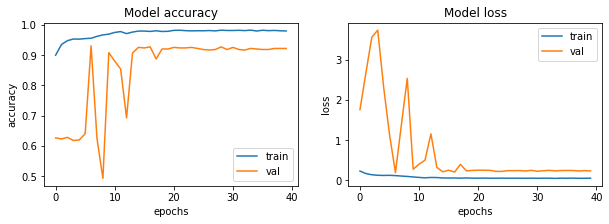

In [13]:
### Loss and accuracy plot
fig, ax = plt.subplots(1,2, figsize=(10,3))
ax= ax.ravel()

for i, met in enumerate(['accuracy','loss']):
    ax[i].plot(histo.history[met])
    ax[i].plot(histo.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### Observations

- According to the accuracy and loss plots, the model shows a good performance.

- The model is converging which can be observed from the decrease in the train and validation loss along epochs. Also, it can reach 92% validation accuracy.

In [14]:
### Predition and evaluating the model with test data
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data).flatten()

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

CONFUSION MATRIX ------------------
[[194  40]
 [  6 384]]

TEST METRICS ----------------------
Accuracy: 92.62820512820514%
Precision: 90.56603773584906%
Recall: 98.46153846153847%
F1-score: 94.34889434889435


### Observations 

- The model with the test data reach an accuracy of 92.62% which is quite good considering the size of data that is used. 

- By analyzing the confusion matrix, we can see that the model is so good at identifying pneumonia images as 384 out of 390 pneumonia images were correctly classified. However, with the normal images, the model has a modest tendency to label them as pneumonia images, resulting in a 17% false-positive rate.

